Generic CNN based on TensorFlow that classifies the two possible outputs of a blackbox function based on input bitstrings. The CNN will take a bitstring of length n as input and output a binary classification (0 or 1).

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the CNN model
def create_model(input_shape):
    model = tf.keras.Sequential()
    # Add a convolutional layer with 32 filters and 3x3 kernel size
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    # Add a max pooling layer
    model.add(layers.MaxPooling2D((2,2)))
    # Add another convolutional layer with 64 filters and 3x3 kernel size
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    # Add a max pooling layer
    model.add(layers.MaxPooling2D((2,2)))
    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())
    # Add a dense layer with 64 units
    model.add(layers.Dense(64, activation='relu'))
    # Add the output layer with a single unit and sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

Let's retrieve measurement data for the two global charges of interest Q0=L/2, Q1=L/2+1 

In [47]:
# retrieve data 
import numpy as np 
p = 0.0
number_shots = 1000 
circuit_iter = 1
L = 12
depth = L-1 # samples will have depth = L-1 since they exclude very last layer containing final measurements
measurement_record_0 = np.load("../data/measurement_record_L_{}_p_{}_Q_{}_numbershots_{}_iter_{}.npy".format(L,p,0,number_shots,circuit_iter))
measurement_record_1 = np.load("../data/measurement_record_L_{}_p_{}_Q_{}_numbershots_{}_iter_{}.npy".format(L,p,1,number_shots,circuit_iter))
measurement_records = np.concatenate([measurement_record_0,measurement_record_1],axis=0)
num_meas_records_0 = len(measurement_record_0[:,0,0])
num_meas_records_1 = len(measurement_record_1[:,0,0])   
num_meas_records = num_meas_records_0+num_meas_records_1
charge_output_0 = np.zeros(num_meas_records_0)
charge_output_1 = np.ones(num_meas_records_1)
charge_output = np.concatenate([charge_output_0,charge_output_1],axis=0)
p = np.random.permutation(num_meas_records) 
data = measurement_records[p,:,:]
labels = charge_output[p]
test_percentage = 0.2 
train_percentage = 1 - test_percentage 
number_samples = len(measurement_records)
train_data_number_samples = round(train_percentage * number_samples)
train_data = data[0:train_data_number_samples,:,:]
train_labels = labels[0:train_data_number_samples]
test_data = data[train_data_number_samples:number_samples,:,:]
test_labels = labels[train_data_number_samples:number_samples]


# Create the model with input shape (n, 1)
model = create_model(input_shape=(depth,L,1))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#measurement_records = np.zeros(2,np.shape(measurement_record_0))

In [48]:
# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32) 

# test the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/10
100/100 [==============================] - 3s 4ms/step - loss: 0.6477 - accuracy: 0.6192
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5856 - accuracy: 0.6846
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5670 - accuracy: 0.6971
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5491 - accuracy: 0.7197
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.7250
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 0.5365 - accuracy: 0.7313
Epoch 7/10
100/100 [==============================] - 0s 4ms/step - loss: 0.5369 - accuracy: 0.7297
Epoch 8/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5253 - accuracy: 0.7319
Epoch 9/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5245 - accuracy: 0.7438
Epoch 10/10
25/25 [==============================] - 0s 2ms/step - loss: 0.5420 - accuracy: 0.7243
T

Text(0, 0.5, 'accuracy')

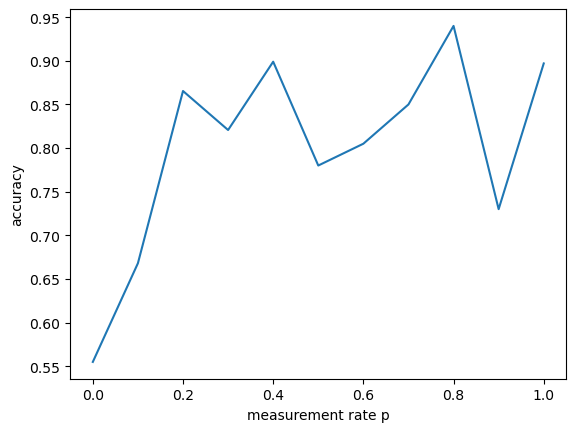

In [40]:
import matplotlib.pyplot as plt 
val_accuracy = [0.5549, 0.668, 0.8654, 0.8207, 0.899, 0.78, 0.8050, 0.85, 0.94, 0.73, 0.897]
# val_accuracy_0.5 = 0.8263
meas_probas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.plot(meas_probas, val_accuracy)
plt.xlabel('measurement rate p')
plt.ylabel('accuracy')

This will train the model for 10 epochs with a batch size of 32 and a validation split of 0.2. During training, the model will update its weights to minimize the binary crossentropy loss between the predicted output and the true output labels. Once trained, the model can be used to classify new input bitstrings by calling the predict function:

In [114]:
# Predict the output for a new input bitstring
print(len(measurement_record_1))
new_bitstring = measurement_records[102:103,:,:]
print(np.shape(new_bitstring))
predicted_output = model.predict(new_bitstring)
print(predicted_output)


99
(1, 11, 12)
1/1 [==============================] - 0s 28ms/step
[[0.9978032]]


This will return the predicted output label for the new input bitstring, which will be a value between 0 and 1 representing the probability that the blackbox function will output 1 for that input. The predicted output can be thresholded to obtain a binary classification by setting a threshold value, such as 0.5:

In [ ]:
# Threshold the predicted output to obtain a binary classification
binary_output = 1 if predicted_output >= 0.5 else 0
